# Black Sea altimetry interpolation.
Application demonstrating the use of `DIVAnd` on along-track altimetry measurements in the Black Sea.

In [21]:
using DIVAnd
using NCDatasets
using PyPlot
using Dates
push!(LOAD_PATH, "/home/ctroupin/Projects/Altimetry-Interpolation/julia")
using DivandAltimetry
using Revise

## User inputs

### Domain of interest, resolution
The goal is to take the same grid as the L4 (gridded) products.

In [2]:
avisoL4file = "../data/nrt_blacksea_allsat_phy_l4_20190601_20190607.nc"
gridval,griderr,gridlon,gridlat,gridtime = DivandAltimetry.loadaviso_gridded(avisoL4file);
gridval = coalesce.(gridval, NaN);

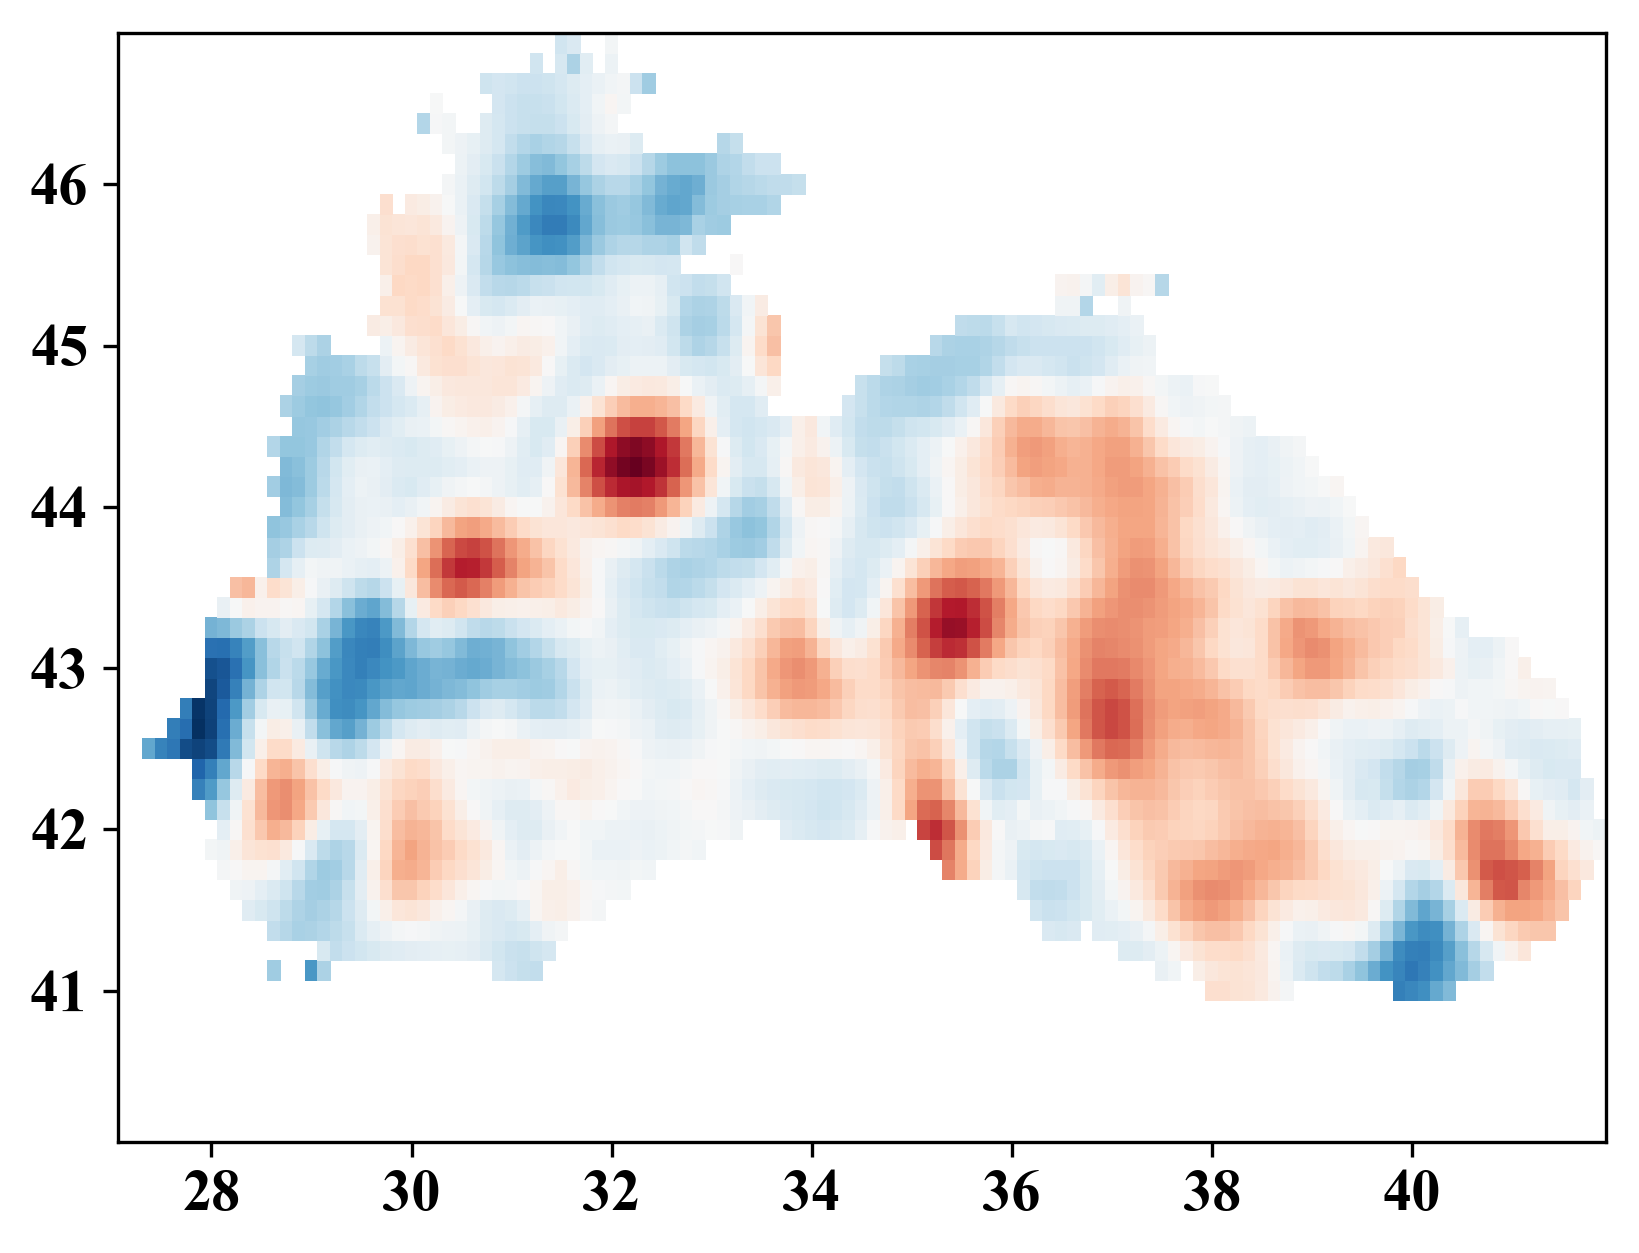

In [3]:
PyPlot.pcolormesh(gridlon, gridlat, transpose(gridval[:,:,1]), cmap=PyPlot.cm.RdBu_r)
PyPlot.show()

### Period of interest

In [89]:
datestart = DateTime(2017, 3, 1)
dateend = DateTime(2017, 3, 10)
Δt = 1.
timestart = datestart.instant.periods.value / (24 * 3600. * 1000.);
timeend = dateend.instant.periods.value / (24 * 3600. * 1000.);
gridtime = timestart:Δt:timeend;
@info(length(gridtime));

┌ Info: 10
└ @ Main In[89]:7


### Land-sea mask

In [90]:
bathfile = "../data/gebco_30sec_4.nc";

In [18]:
xi,yi,mask = load_mask(bathfile,true,gridlon, gridlat, 0.0);
@info(size(mask));

┌ Info: (120, 56)
└ @ Main In[18]:2


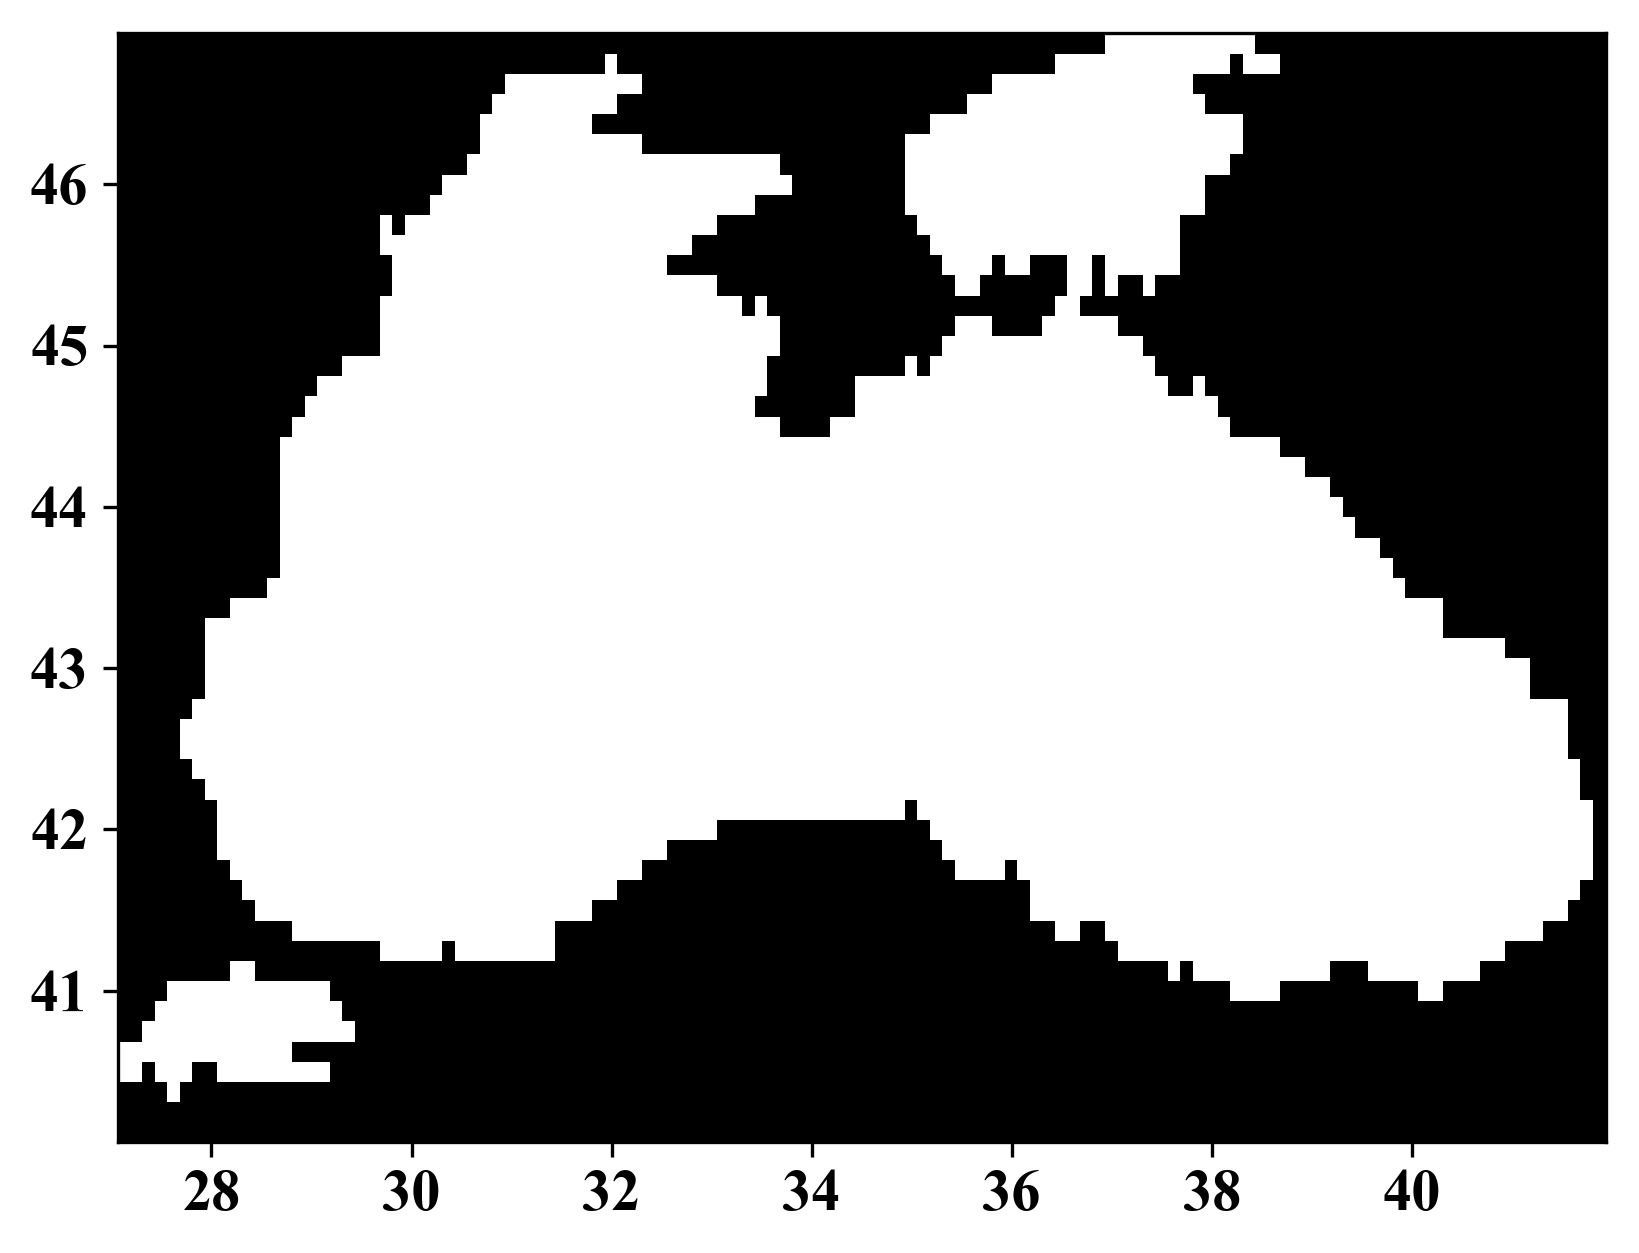

In [6]:
PyPlot.pcolormesh(xi, yi, transpose(mask), cmap=PyPlot.cm.binary_r)
PyPlot.show()

### Along-track SLA

In [47]:
datadir = "../data/SEALEVEL_BS_PHY_L3_NRT_OBSERVATIONS_008_039/";

In [48]:
filelist2017 = DivandAltimetry.get_file_list(datadir, 2017);

┌ Info: Found 930 files
└ @ DivandAltimetry /home/ctroupin/Projects/Altimetry-Interpolation/julia/DivandAltimetry.jl:45


In [49]:
obsvallist,obslonlist,obslatlist,obstimelist = DivandAltimetry.loadaviso_alongtrack(filelist2017);
@info("Working on $(length(obslatlist)) data points")

┌ Info: Working on 60580 data points
└ @ Main In[49]:2


In [55]:
obstime = [dd.instant.periods.value / (24 * 3600. * 1000.) for dd in obstimelist];

### Metrics

In [74]:
_, (px, py, pt), (xi, yi, ti) = DIVAnd.DIVAnd_rectdom(gridlon, gridlat, gridtime);

## Interpolation
### Analysis Parameters

In [91]:
# correlation length (lon, lat in degrees, time in days)
len = (1., 1., 4.);
# obs. error variance normalized by the background error variance
epsilon2 = 0.1;

In [92]:
mask0 = trues(size(px));
size(px)

(120, 56, 31)

In [87]:
@time sla_grid, s = DIVAnd.DIVAndrun(mask0, (px, py, pt), (xi, yi, ti), (obslonlist, obslatlist, obstime), 
    obsvallist, len, epsilon2; alphabc=2);

424.905088 seconds (4.50 k allocations: 15.533 GiB, 2.33% gc time)


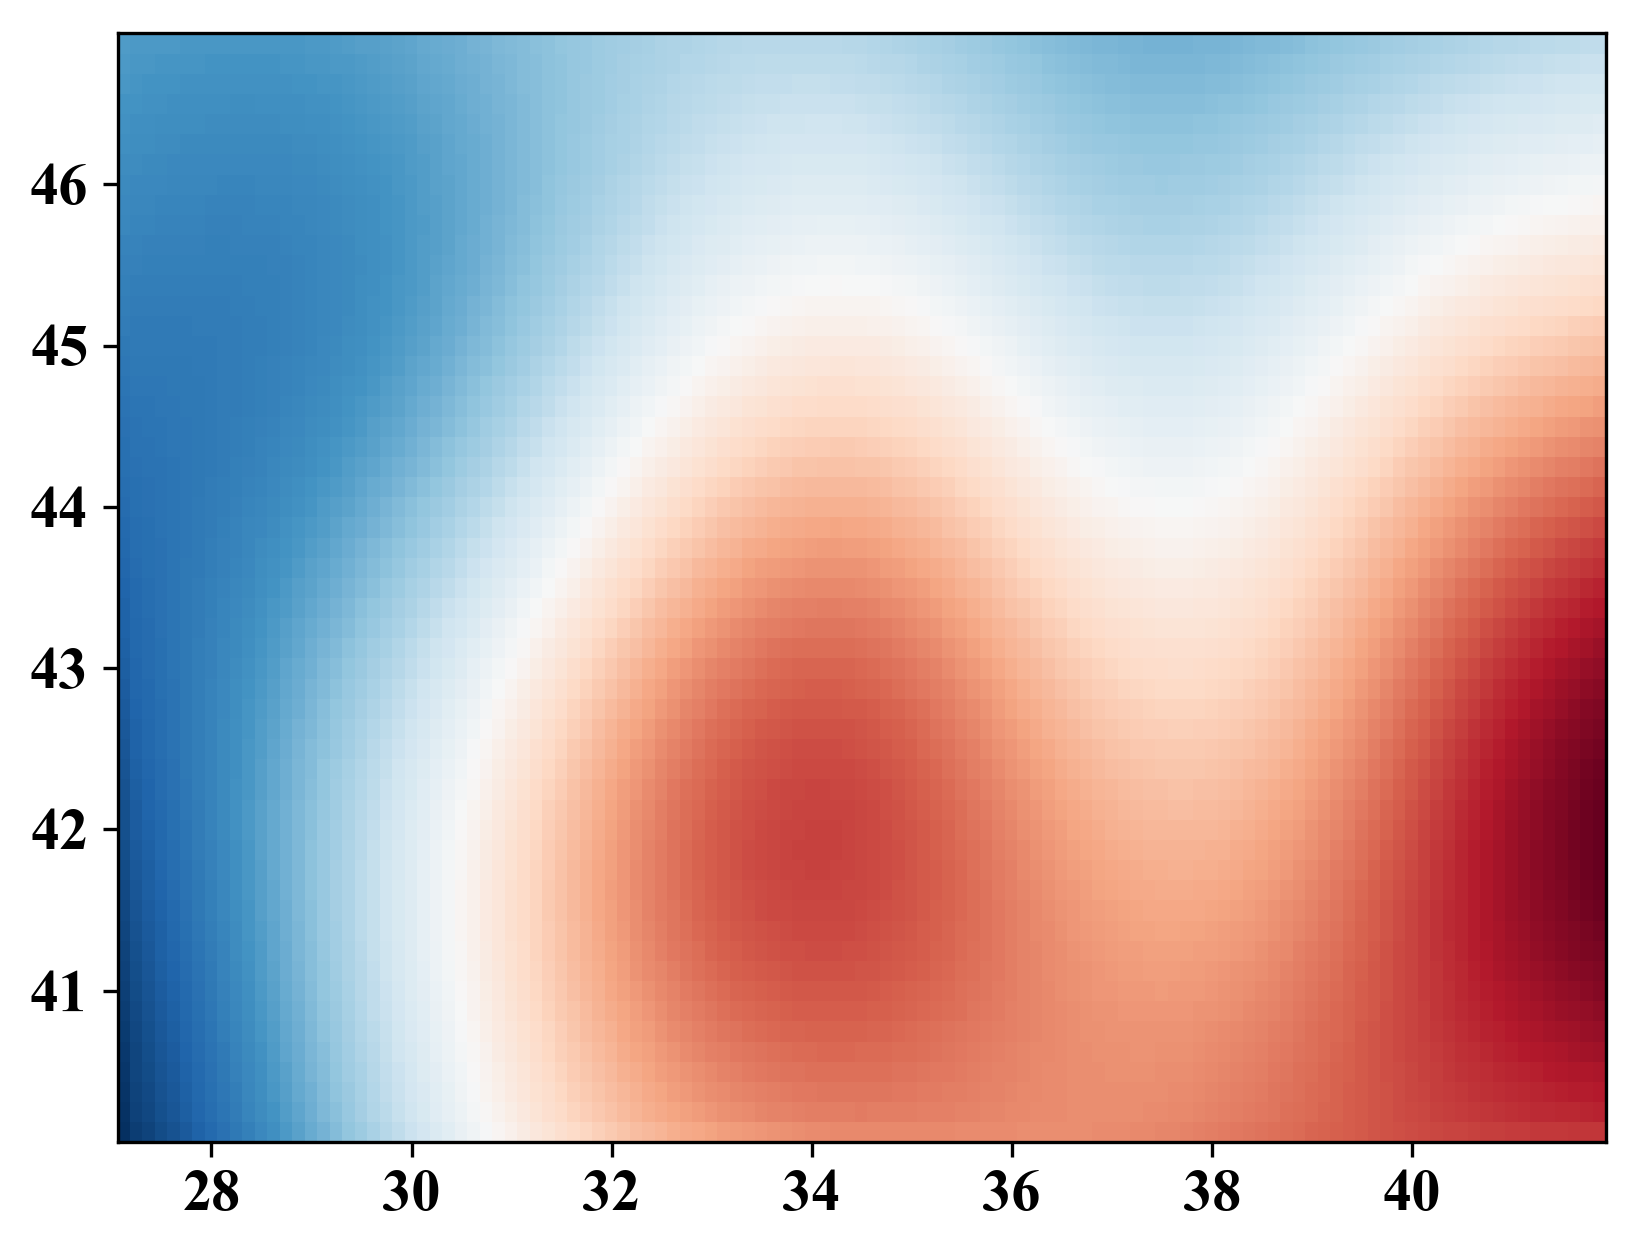

In [88]:
PyPlot.pcolormesh(gridlon, gridlat, transpose(fi[:,:,1]), cmap=PyPlot.cm.RdBu_r)
PyPlot.show()

## Export results to netCDF

In [12]:
info("Writing interpolated field in file:\n", resultfile)
sz = size(mask)
dims = [NcDim("longitude",sz[1]), NcDim("latitude",sz[2]), NcDim("time",sz[3])];
nc = NetCDF.create(resultfile, NcVar("ADT", dims))
nc["ADT"][:,:, :] = fi
NetCDF.close(nc);

UndefVarError: UndefVarError: info not defined

# Plotting

Done in [another notebook in Python](../python/plot_AVISO_divand.ipynb) due to a problem with Julia / matplotlib.